In [3]:
from qutip import *
import matplotlib.pyplot as plt
import numpy as np
from helper_code_qutip import *
from scipy import integrate
import scipy.io

In [4]:
def create_hamiltonian3(w0list,glist,delta,N):
    
    H=(w0list[N-1])*create_projector0(N,N)

    for k in range(1,N):
        H=H+(w0list[k-1])*create_projector0(N,k) + glist[k-1]*(create_sigmax(N,k)*create_sigmax(N,k+1) + create_sigmay(N,k)*create_sigmay(N,k+1) + delta*create_sigmaz(N,k)*create_sigmaz(N,k+1))

    return H

In [121]:
print(gvals_ext)

[0.001, 0.0011836734693877551, 0.0013673469387755102, 0.0015510204081632655, 0.0017346938775510204, 0.0019183673469387757, 0.002102040816326531, 0.002285714285714286, 0.0024693877551020408, 0.002653061224489796, 0.0028367346938775514, 0.0030204081632653063, 0.0032040816326530616, 0.0033877551020408164, 0.0035714285714285718, 0.0037551020408163266, 0.003938775510204082, 0.004122448979591837, 0.004306122448979592, 0.004489795918367347, 0.004673469387755102, 0.004857142857142858, 0.0050408163265306125, 0.005224489795918367, 0.005408163265306123, 0.005591836734693878, 0.005775510204081633, 0.005959183673469389, 0.0061428571428571435, 0.006326530612244898, 0.006510204081632653, 0.006693877551020409, 0.006877551020408164, 0.007061224489795919, 0.0072448979591836745, 0.007428571428571429, 0.007612244897959184, 0.007795918367346939, 0.007979591836734695, 0.00816326530612245, 0.008346938775510205, 0.00853061224489796, 0.008714285714285716, 0.00889795918367347, 0.009081632653061226, 0.0092653061

In [5]:
Tc_list = [0.001,0.18,0.20]
Th_list = [0.4,0.7,1.0] #For some reason, integral diverges outside this range


betalist1 = [1/Tc for Tc in Tc_list]
betalist2 = [1/Th for Th in Th_list]

gvals1 = list(np.linspace(0.001,0.01,50))
gvals2 = list(np.linspace(0.01,1,150))
gvals3 = list(np.linspace(1,10,50))

## Add the two lists
gvals = gvals1 + gvals2
gvals_ext = gvals + gvals3


print(len(betalist1),len(betalist2))

redfield_ss = []
lle_ss = []
lle_ss2 = []
e = 0.01
for beta2 in betalist2:
    list_red = []
    list_lle = []
    list_lle2 = []
    for g in gvals_ext:
        limit_value=700
        b=500
        N=2
        w0min=1
        w0max=w0min+e
        delta=1
        gmin=g
        gmax=g
        beta1 = 1/0.1  #Tc = 0.1
            
        w0list=np.linspace(w0min,w0max,N)
        glist=np.linspace(gmin,gmax,N-1)
            
        tb=0.01
        epsilon=1
        gamma1=1e-3 #gamma1 is the coupling to left bath. It shows up in spectral bath function
        gamma2=1.1e-2   #gamma2 is the coupling to the right bath.    
            
            

        mu=0
            
            
        delta=1
        mu1=mu
        mu2=mu

        H_S=create_hamiltonian2(w0list,glist,N)
    
    
        c_N=create_sm(N,N)  # we couple the Nth spin to the bath
        c_1=create_sm(N,1)
        
        
        
        eigenergies,eigstates=H_S.eigenstates()
        
        #print("eigenenergies are : ",eigenergies)
        
        spectrum=max(eigenergies)-min(eigenergies)
        
        
        
        number=len(eigenergies)
        
        integral11=np.empty((number,number),dtype=np.cdouble) #stores J * N integral for left bath
        integral12=np.empty((number,number),dtype=np.cdouble) # stores J integral (just to check) for the left bath
        integral21=np.empty((number,number),dtype=np.cdouble) #stores J*N integral for right bath
        integral22=np.empty((number,number),dtype=np.cdouble)

        print("Integral calculations at beta2 = {} and e = {} are : ".format(beta2,e))

        for i in range(number):
            for k in range(number):
                freq=eigenergies[k]-eigenergies[i]
                print(f"Absolute frequency  for i = {i}, k = {k} is ",np.absolute(freq))
                #print(i,k,freq)
                if( np.absolute(freq) >= 1/10**10):
                    integral11[i,k]=(-1.0j/(2*np.pi))*integrate.quad(func1,0,b,args=(tb,beta2,mu2,gamma1),limit=limit_value,weight='cauchy',wvar=eigenergies[k]-eigenergies[i])[0] #func 1
                    integral12[i,k]=(-1.0j/(2*np.pi))*integrate.quad(spectral_bath,0,b,args=(tb,gamma1),limit=limit_value,weight='cauchy',wvar=eigenergies[k]-eigenergies[i])[0]  #left bath done
                    integral21[i,k]=(-1.0j/(2*np.pi))*integrate.quad(func1,0,b,args=(tb,beta1,mu1,gamma2),limit=limit_value,weight='cauchy',wvar=eigenergies[k]-eigenergies[i])[0] #func 1
                    integral22[i,k]=(-1.0j/(2*np.pi))*integrate.quad(spectral_bath,0,b,args=(tb,gamma2),limit=limit_value,weight='cauchy',wvar=eigenergies[k]-eigenergies[i])[0]  #right bath
        
                if (np.absolute(freq)<=1/10**10):  #The problem is arising here....
                    integral11[i,k]=(-1.0j/(2*np.pi))*integrate.quad(func2,0,b,args=(tb,beta2,mu2,gamma1),limit=limit_value)[0]
                    integral12[i,k]=(-1.0j/(2*np.pi))*integrate.quad(spectral_bath_2,0,b,args=(tb,gamma1),limit=limit_value)[0]
                    integral21[i,k]=(-1.0j/(2*np.pi))*integrate.quad(func2,0,b,args=(tb,beta1,mu1,gamma2),limit=limit_value)[0]
                    integral22[i,k]=(-1.0j/(2*np.pi))*integrate.quad(spectral_bath_2,0,b,args=(tb,gamma2),limit=limit_value)[0]
                
            
            #expected=1.0j*(eigenergies[k]-eigenergies[i])/(2*tb*tb)
        #        print(i,k,integral2[i,k],expected)
    
    
        # PAY ATTENTION TO THE WAY THESE COEFFICIENTS ARE BEING COMPUTED
    
        constant12=np.empty((number,number),dtype=np.cdouble)
        constant11=np.empty((number,number),dtype=np.cdouble)
        constant21=np.empty((number,number),dtype=np.cdouble)
        constant22=np.empty((number,number),dtype=np.cdouble)
        
        
        
        for i in range(number):
            for k in range(number):
                constant12[i,k]=integral12[i,k]+integral11[i,k]+0.5*(spectral_bath(eigenergies[k]-eigenergies[i],tb,gamma1)+func1(eigenergies[k]-eigenergies[i],tb,beta2,mu2,gamma1))    #full coefficient created this is nbar+1
                constant11[i,k]=integral11[i,k]+0.5*func1(eigenergies[k]-eigenergies[i],tb,beta2,mu2,gamma1)                                       # the full coefficient is created
                
                constant22[i,k]=integral22[i,k]+integral21[i,k]+0.5*(spectral_bath(eigenergies[k]-eigenergies[i],tb,gamma2)+func1(eigenergies[k]-eigenergies[i],tb,beta1,mu1,gamma2))    #full coefficient created this is nbar+1
                constant21[i,k]=integral21[i,k]+0.5*func1(eigenergies[k]-eigenergies[i],tb,beta1,mu1,gamma2)   # the full coefficient is created
                #print(i,k,constant11[i,k],constant12[i,k],constant21[i,k],constant22[i,k])
        list1=[]
        list2=[]
        
        
        for i in range(number):
            list1.append([])
            list2.append([])
        
        
        
        matrix=np.zeros((number,number))
        
        dim=[]
        for k in range(N):
            dim.append(2)    
        
        zeromatrix=Qobj(matrix,dims=[dim,dim])
        
        
        indices1=[]
        indices2=[]
        
        
        
        
        for i in range(number):
            for k in range(number):
                list1[i].append(eigstates[i]*eigstates[i].dag()*c_1*eigstates[k]*eigstates[k].dag())
                list2[i].append(eigstates[i]*eigstates[i].dag()*c_N*eigstates[k]*eigstates[k].dag())
                
                if(tracedist(eigstates[i]*eigstates[i].dag()*c_1*eigstates[k]*eigstates[k].dag(),zeromatrix)!=0):
                    indices1.append((i,k))
                if(tracedist(eigstates[i]*eigstates[i].dag()*c_N*eigstates[k]*eigstates[k].dag(),zeromatrix)!=0):
                    indices2.append((i,k))

        pre=-1.0j*H_S
        post=1.0j*H_S
        
        L=spre(pre)+spost(post)
        
        for i in range(number):
            for k in range(number):
                vi=eigstates[i]
                vk=eigstates[k]

                print(constant11[i,k],constant12[i,k])
                
                op1=epsilon*epsilon*constant11[i,k]*vi*vi.dag()*c_1*vk*vk.dag()*c_1.dag()
                op2=epsilon*epsilon*constant12[i,k]*c_1.dag()*vi*vi.dag()*c_1*vk*vk.dag()
                
                op3=epsilon*epsilon*constant11[i,k]*c_1.dag()
                op4=vi*vi.dag()*c_1*vk*vk.dag()
                op5=epsilon*epsilon*constant12[i,k]*c_1.dag()
                
                
                L=L+spre(-op2-op1.dag())+spost(-op1-op2.dag())
                L=L+spre(op3)*spost(op4)+spre(op4)*spost(op5)+spre(op4.dag())*spost(op3.dag()) +spre(op5.dag())*spost(op4.dag())
                
                op1=epsilon*epsilon*constant21[i,k]*vi*vi.dag()*c_N*vk*vk.dag()*c_N.dag()
                op2=epsilon*epsilon*constant22[i,k]*c_N.dag()*vi*vi.dag()*c_N*vk*vk.dag()
                
                op3=epsilon*epsilon*constant21[i,k]*c_N.dag()
                op4=vi*vi.dag()*c_N*vk*vk.dag()
                op5=epsilon*epsilon*constant22[i,k]*c_N.dag()
                
                
                L=L+spre(-op2-op1.dag())+spost(-op1-op2.dag())
                L=L+spre(op3)*spost(op4)+spre(op4)*spost(op5)+spre(op4.dag())*spost(op3.dag()) +spre(op5.dag())*spost(op4.dag())
                
                
                
        #Variables needed for for iterative-lgmres to work. 
        return_info=True
        #print('Redfield Liouvillian constructed, Computing steady-state ...')
        ss_redfield = steadystate(L,return_info=return_info)
        L_eigen = L.eigenenergies()
        print("Smallest eigenvalues of L_red are ", L_eigen[-3:])
        list_red.append(ss_redfield)

################################## Local Lindblad stuff ########################################
        gammah_plus =  gamma1*nbar(1,beta2,mu)
        gammah_minus = gamma1*(nbar(1,beta2,mu)+1)
        gammac_plus = gamma2*nbar(1+e,beta1,mu)  #beta1 is fixed at 1/0.1
        gammac_minus = gamma2*(nbar(1+e,beta1,mu)+1)

        L_lle = spre(-1.0j*(H_S)) + spost(1.0j*(H_S))
        op1 = create_sm(N,1).dag()
        op2 = create_sm(N,N).dag()
        L_lle = L_lle + gammah_plus*(spre(op1)*spost(op1.dag()) - 0.5*spre(op1.dag()*op1) - 0.5*spost(op1.dag()*op1)) + gammah_minus*(spre(op1.dag())*spost(op1) - 0.5*spre(op1*op1.dag()) - 0.5*spost(op1*op1.dag())) + gammac_plus*(spre(op2)*spost(op2.dag()) - 0.5*spre(op2.dag()*op2) - 0.5*spost(op2.dag()*op2)) + gammac_minus*(spre(op2.dag())*spost(op2) - 0.5*spre(op2*op2.dag()) - 0.5*spost(op2*op2.dag()))

        ss_lindblad2 = steadystate(L_lle)
        L_eigen = L_lle.eigenenergies()
        print("Smallest eigenvalues of L_lle are ", L_eigen[-3:])

        list_lle.append(ss_lindblad2)

        ########################## Another Local Lindblad version, with bath and spectral functions involved ###############################

        Delta1=(-1.0*epsilon*epsilon/(2*np.pi))*integrate.quad(spectral_bath,0,b,args=(tb,gamma1),weight='cauchy',wvar=w0list[0])[0] #Delta
        Deltadash1=(-1.0*epsilon*epsilon/(2*np.pi))*integrate.quad(func1,0,b,args=(tb,beta1,mu1,gamma1),weight='cauchy',wvar=w0list[0])[0] #Delta
        
        
        DeltaN=(-1.0*epsilon*epsilon/(2*np.pi))*integrate.quad(spectral_bath,0,b,args=(tb,gamma2),weight='cauchy',wvar=w0list[N-1])[0] #Delta
        DeltadashN=(-1.0*epsilon*epsilon/(2*np.pi))*integrate.quad(func1,0,b,args=(tb,beta2,mu2,gamma2),weight='cauchy',wvar=w0list[N-1])[0] #Delta

        H=H_S  +(Deltadash1+0.5*Delta1)*create_sigmaz(N,1)+(DeltadashN+0.5*DeltaN)*create_sigmaz(N,N) 

        L_lle = spre(-1.0j*(H)) + spost(1.0j*(H))
        op1 = create_sm(N,1).dag()
        op2 = create_sm(N,N).dag()
        L_lle = L_lle + gammah_plus*(spectral_bath(1,tb,1))*(spre(op1)*spost(op1.dag()) - 0.5*spre(op1.dag()*op1) - 0.5*spost(op1.dag()*op1)) + gammah_minus*(spectral_bath(1,tb,1))*(spre(op1.dag())*spost(op1) - 0.5*spre(op1*op1.dag()) - 0.5*spost(op1*op1.dag())) + gammac_plus*(spectral_bath(1+e,tb,1))*(spre(op2)*spost(op2.dag()) - 0.5*spre(op2.dag()*op2) - 0.5*spost(op2.dag()*op2)) + gammac_minus*(spectral_bath(1+e,tb,1))*(spre(op2.dag())*spost(op2) - 0.5*spre(op2*op2.dag()) - 0.5*spost(op2*op2.dag()))

        ss_lindblad2 = steadystate(L_lle)
        L_eigen = L_lle.eigenenergies()
        print("Smallest eigenvalues of L_lle2 are ", L_eigen[-3:])

        list_lle2.append(ss_lindblad2)
    redfield_ss.append(list_red)
    lle_ss.append(list_lle)
    lle_ss2.append(list_lle2)

3 3
Integral calculations at beta2 = 2.5 and e = 0.01 are : 
Absolute frequency  for i = 0, k = 0 is  0.0
Absolute frequency  for i = 0, k = 1 is  0.9999009804864072
Absolute frequency  for i = 0, k = 2 is  1.0100990195135928
Absolute frequency  for i = 0, k = 3 is  2.01
Absolute frequency  for i = 1, k = 0 is  0.9999009804864072
Absolute frequency  for i = 1, k = 1 is  0.0
Absolute frequency  for i = 1, k = 2 is  0.010198039027185635
Absolute frequency  for i = 1, k = 3 is  1.0100990195135926
Absolute frequency  for i = 2, k = 0 is  1.0100990195135928
Absolute frequency  for i = 2, k = 1 is  0.010198039027185635
Absolute frequency  for i = 2, k = 2 is  0.0
Absolute frequency  for i = 2, k = 3 is  0.999900980486407
Absolute frequency  for i = 3, k = 0 is  2.01
Absolute frequency  for i = 3, k = 1 is  1.0100990195135926
Absolute frequency  for i = 3, k = 2 is  0.999900980486407
Absolute frequency  for i = 3, k = 3 is  0.0
(nan-infj) (nan-infj)
(4.4275488945329176e-05+5.275368635140987e-

/var/folders/ys/hsq5k3zs70b8y915g7tk_yx00000gn/T/ipykernel_79993/3356466917.py:166: RuntimeWarning: invalid value encountered in scalar multiply
  op1=epsilon*epsilon*constant11[i,k]*vi*vi.dag()*c_1*vk*vk.dag()*c_1.dag()
/var/folders/ys/hsq5k3zs70b8y915g7tk_yx00000gn/T/ipykernel_79993/3356466917.py:167: RuntimeWarning: invalid value encountered in scalar multiply
  op2=epsilon*epsilon*constant12[i,k]*c_1.dag()*vi*vi.dag()*c_1*vk*vk.dag()
/var/folders/ys/hsq5k3zs70b8y915g7tk_yx00000gn/T/ipykernel_79993/3356466917.py:169: RuntimeWarning: invalid value encountered in scalar multiply
  op3=epsilon*epsilon*constant11[i,k]*c_1.dag()
/var/folders/ys/hsq5k3zs70b8y915g7tk_yx00000gn/T/ipykernel_79993/3356466917.py:171: RuntimeWarning: invalid value encountered in scalar multiply
  op5=epsilon*epsilon*constant12[i,k]*c_1.dag()
/var/folders/ys/hsq5k3zs70b8y915g7tk_yx00000gn/T/ipykernel_79993/3356466917.py:177: RuntimeWarning: invalid value encountered in scalar multiply
  op1=epsilon*epsilon*const

ValueError: array must not contain infs or NaNs

In [182]:
def negativity1(rho):
    a1 = rho[0,0]
    a4 = rho[3,3]
    c = np.abs(rho[1,2])
    val = 0.5*(np.sqrt(4*c**2 + (a1-a4)**2) - (a1+a4))  #How did it know the function?? Very cool
    if val < 0:
        return 0
    else:
        return val

def negativity_plot(Th_list,gvals,reduced_dm_list1,reduced_dm_list2):
    red_neg = []
    for i in range(len(Th_list)):
        neg_list1 = []
        neg_list2 = []
        for j in range(len(gvals)):
            if gvals[j] < 0.1:
                neg_list1.append(20*negativity1(reduced_dm_list1[i][j]))
                neg_list2.append(20*negativity1(reduced_dm_list2[i][j]))
            else:
                neg_list1.append(negativity1(reduced_dm_list1[i][j]))
                neg_list2.append(negativity1(reduced_dm_list2[i][j]))

        ##Calculate the KL divergence between the two lists
        kl_div = 0
        for k in range(len(neg_list1)):
            if neg_list1[k] != 0 and neg_list2[k] != 0:
                kl_div += -neg_list1[k]*np.log(neg_list1[k]/neg_list2[k])
        print(f'KL divergence for Th = {Th_list[i]} is {kl_div}')
        plt.plot(gvals,neg_list1,'-',label='Th/Eh = '+str(Th_list[i]) + ',LLE')
        plt.plot(gvals,neg_list2,'--',label='Th/Eh = '+str(Th_list[i])+ ",RE")
        red_neg.append(neg_list2)

    plt.xlabel('g/Eh')
    plt.ylabel('Negativity (some scaling)')
    #plt.yscale('logit')
    plt.xscale('log')
    plt.title(f'Negativity comp for different Th at e = {e}, ph = 1e-3, pc = 1.1e-2')
    plt.legend()

    plt.show()

    return red_neg  #Return redfield negs

KL divergence for Th = 0.4 is (0.002332972472072361+0j)
KL divergence for Th = 0.7 is (0.029126250112887643+0j)
KL divergence for Th = 1.0 is (0.06341340164125507+0j)


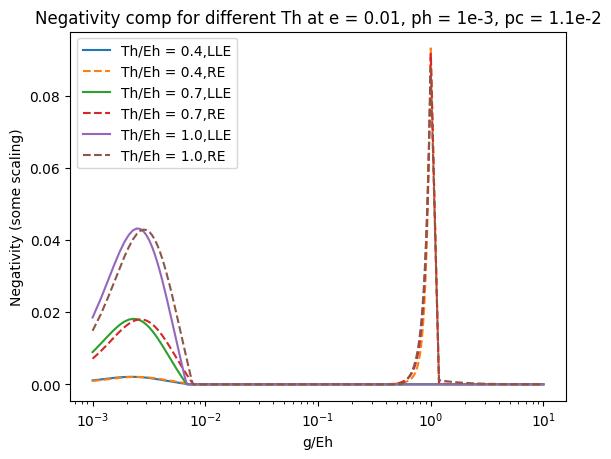

In [183]:
red_neg = negativity_plot(Th_list,gvals_ext,lle_ss2,redfield_ss)

KL divergence for Th = 0.4 is (0.0055263473386804665+0j)
KL divergence for Th = 0.7 is (0.03834822939510256+0j)
KL divergence for Th = 1.0 is (0.07419302846868195+0j)


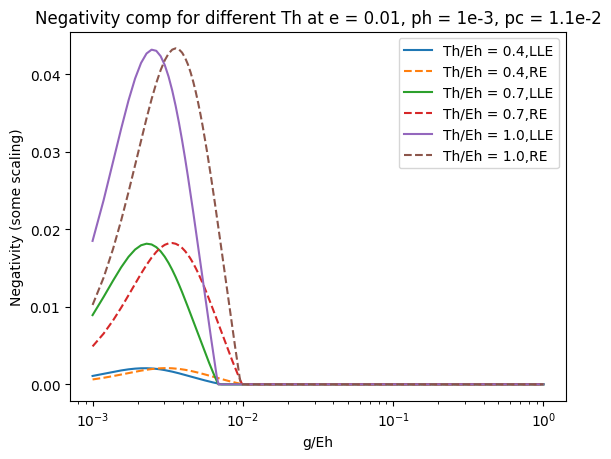

In [138]:
negativity_plot(Th_list,gvals_ext,lle_ss2,lle_ss)

In [157]:
lle_ss2[1][2]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1.29008914e-04+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         1.59519476e-01+0.j
  1.64773987e-02+0.01987537j 0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         1.64773987e-02-0.01987537j
  4.85408753e-03+0.j         0.00000000e+00+0.j        ]
 [0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         8.35497428e-01+0.j        ]]

In [158]:
lle_ss[1][2]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 7.34491928e-05+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          1.75360872e-01+0.j
  -1.68849299e-02+0.01066391j  0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j         -1.68849299e-02-0.01066391j
   2.61854980e-03+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          8.21947129e-01+0.j        ]]

In [141]:
def dissipator(op,rho):
    return op*rho*op.dag() - 0.5*op.dag()*op*rho - 0.5*rho*op.dag()*op

In [165]:
def heat_current_h(rho,beta2,g,e):
    gammah_plus =  gamma1*nbar(1,beta2,0)
    gammah_minus = gamma1*(nbar(1,beta2,0)+1)

    op1 = create_sm(N,1).dag()

    op_com = gammah_plus*dissipator(op1,rho) + gammah_minus*dissipator(op1.dag(),rho)
    H_S=create_hamiltonian2([1,1+e],[g,g],N)

    return (H_S*op_com).tr()

def heat_current_c(rho,g,e):
    gammac_plus = gamma2*nbar(1+e,beta1,0)  #beta1 is fixed at 1/0.1
    gammac_minus = gamma2*(nbar(1+e,beta1,0)+1)

    op2 = create_sm(N,N).dag()

    op_com = gammac_plus*dissipator(op2,rho) + gammac_minus*dissipator(op2.dag(),rho)
    H_S=create_hamiltonian2([1,1+e],[g,g],N)

    return (H_S*op_com).tr()

In [177]:
def curr_plot(Th_list,gvals,reduced_dm_list1,reduced_dm_list2):
    red_neg = []
    for i in range(len(Th_list)):
        neg_list1 = []
        neg_list2 = []
        for j in range(len(gvals)):
            neg_list1.append(heat_current_h(reduced_dm_list1[i][j],betalist2[i],gvals[j],e) - heat_current_c(reduced_dm_list1[i][j],gvals[j],e))
            neg_list2.append(heat_current_h(reduced_dm_list2[i][j],betalist2[i],gvals[j],e) - heat_current_c(reduced_dm_list2[i][j],gvals[j],e))
        plt.plot(gvals,neg_list1,'-',label='Th/Eh = '+str(Th_list[i]) + ',LLE')
        plt.plot(gvals,neg_list2,'--',label='Th/Eh = '+str(Th_list[i])+ ",RE")
        red_neg.append(neg_list2)

    plt.xlabel('g/Eh')
    plt.ylabel('Heat current')
    plt.xscale('log')
    plt.title(f'Current comp for different Th at e = {e}, ph = 1e-3, pc = 1.1e-2')
    plt.legend()

    plt.show()

    return red_neg #return redfield currents

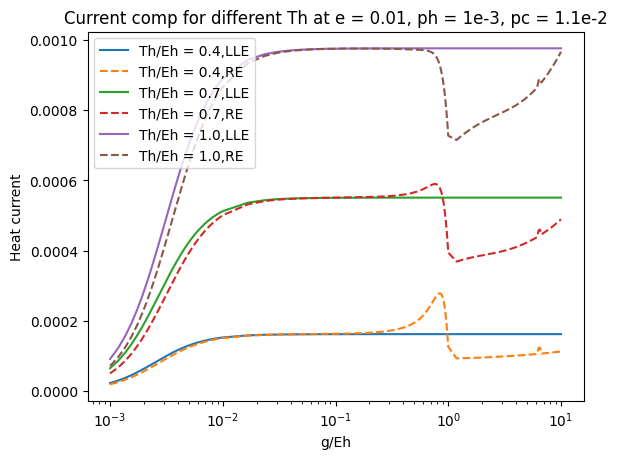

In [178]:
red_curr = curr_plot(Th_list,gvals_ext,lle_ss2,redfield_ss)  

In [184]:
print(red_neg)
print(red_curr)

[[(0.0009263295493711077+0j), (0.0011892638743404849+0j), (0.0014292489631162475+0j), (0.0016348496698037618+0j), (0.001799720839862351+0j), (0.0019218516233354688+0j), (0.002002505128201326+0j), (0.0020451307217295156+0j), (0.002054416492544009+0j), (0.0020355538437111242+0j), (0.001993720909492236+0j), (0.0019337559631227297+0j), (0.0018599785052375584+0j), (0.0017761155890338998+0j), (0.0016852972678493838+0j), (0.0015900934056056748+0j), (0.0014925720770775364+0j), (0.0013943663851423427+0j), (0.0012967415094844448+0j), (0.0012006573287903777+0j), (0.0011068243178169457+0j), (0.0010157519138298543+0j), (0.0009277894333692416+0j), (0.0008431601009639689+0j), (0.0007619889734744589+0j), (0.0006843256080002469+0j), (0.0006101622958532005+0j), (0.0005394486134457921+0j), (0.0004721029494381135+0j), (0.0004080215724566738+0j), (0.0003470857133458516+0j), (0.0002891670543792024+0j), (0.00023413194746968458+0j), (0.00018184462286963132+0j), (0.0001321695999345618+0j), (8.497346984603915e-

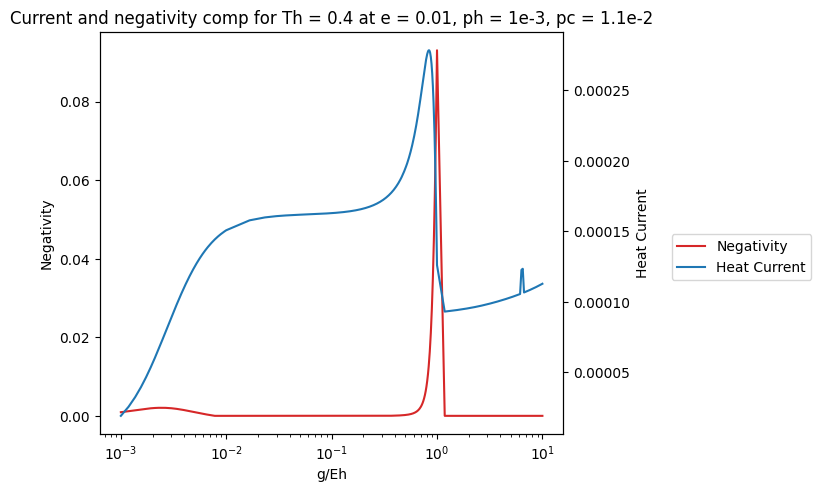

In [189]:
#Now we plot both current and negativity on the same plot

#Plot both averages on same axis, have different scales on top and bottom of graph

i = 0

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel(r"g/Eh")
ax1.set_ylabel(r"Negativity")
ax1.set_xscale('log')
ax1.plot(gvals_ext,red_neg[i], color=color, label = "Negativity")
ax1.tick_params(axis='y')
#ax1.legend(loc = "lower right")

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r"Heat Current")  # we already handled the y-label with ax1
ax2.set_xscale('log')
ax2.plot(gvals_ext,red_curr[i], color=color, label = "Heat Current")
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f"Current and negativity comp for Th = {Th_list[i]} at e = {e}, ph = 1e-3, pc = 1.1e-2")
plt.show()